# Demos of each method for n = 3

In [47]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import UnitaryGate
from qiskit.synthesis import OneQubitEulerDecomposer
from qiskit import *
from qiskit_aer import Aer

import matplotlib.pyplot as plt

import numpy as np

## Select method

The following function implements the select method. In this demo, we will test its operation by implementing it on a test function for all different combinations of input $x \in \mathbb{F}_2^3$.

In [2]:
def select_qrom(n, d, f):
    #n: number of input qubits
    #d: number of output qubits
    #f: function mapping bitstrings of length n to bitstrings of length d

    quantum_registerX = QuantumRegister(n, name="x")
    quantum_registerY = QuantumRegister(d, name="y")
    qrom_circuit = QuantumCircuit(quantum_registerX, quantum_registerY, name="Select")

    for i in range(2**n):
        x_bits = format(i, f'0{n}b')  
        f_x = f(x_bits)    
        if '1' in f_x:
            for i in range(n):
                if( x_bits[i] == '0'):
                    qrom_circuit.x(quantum_registerX[i])

            for j in range(d):
                if f_x[j] == '1':
                    qrom_circuit.mcx([quantum_registerX[k] for k in range(n)], quantum_registerY[j])
            for i in range(n):
                if( x_bits[i] == '0'):
                    qrom_circuit.x(quantum_registerX[i])
                

    return qrom_circuit


We can write a test function $f: \mathbb{F}_2^3 \to \mathbb{F}_2^5$ to test the method on:

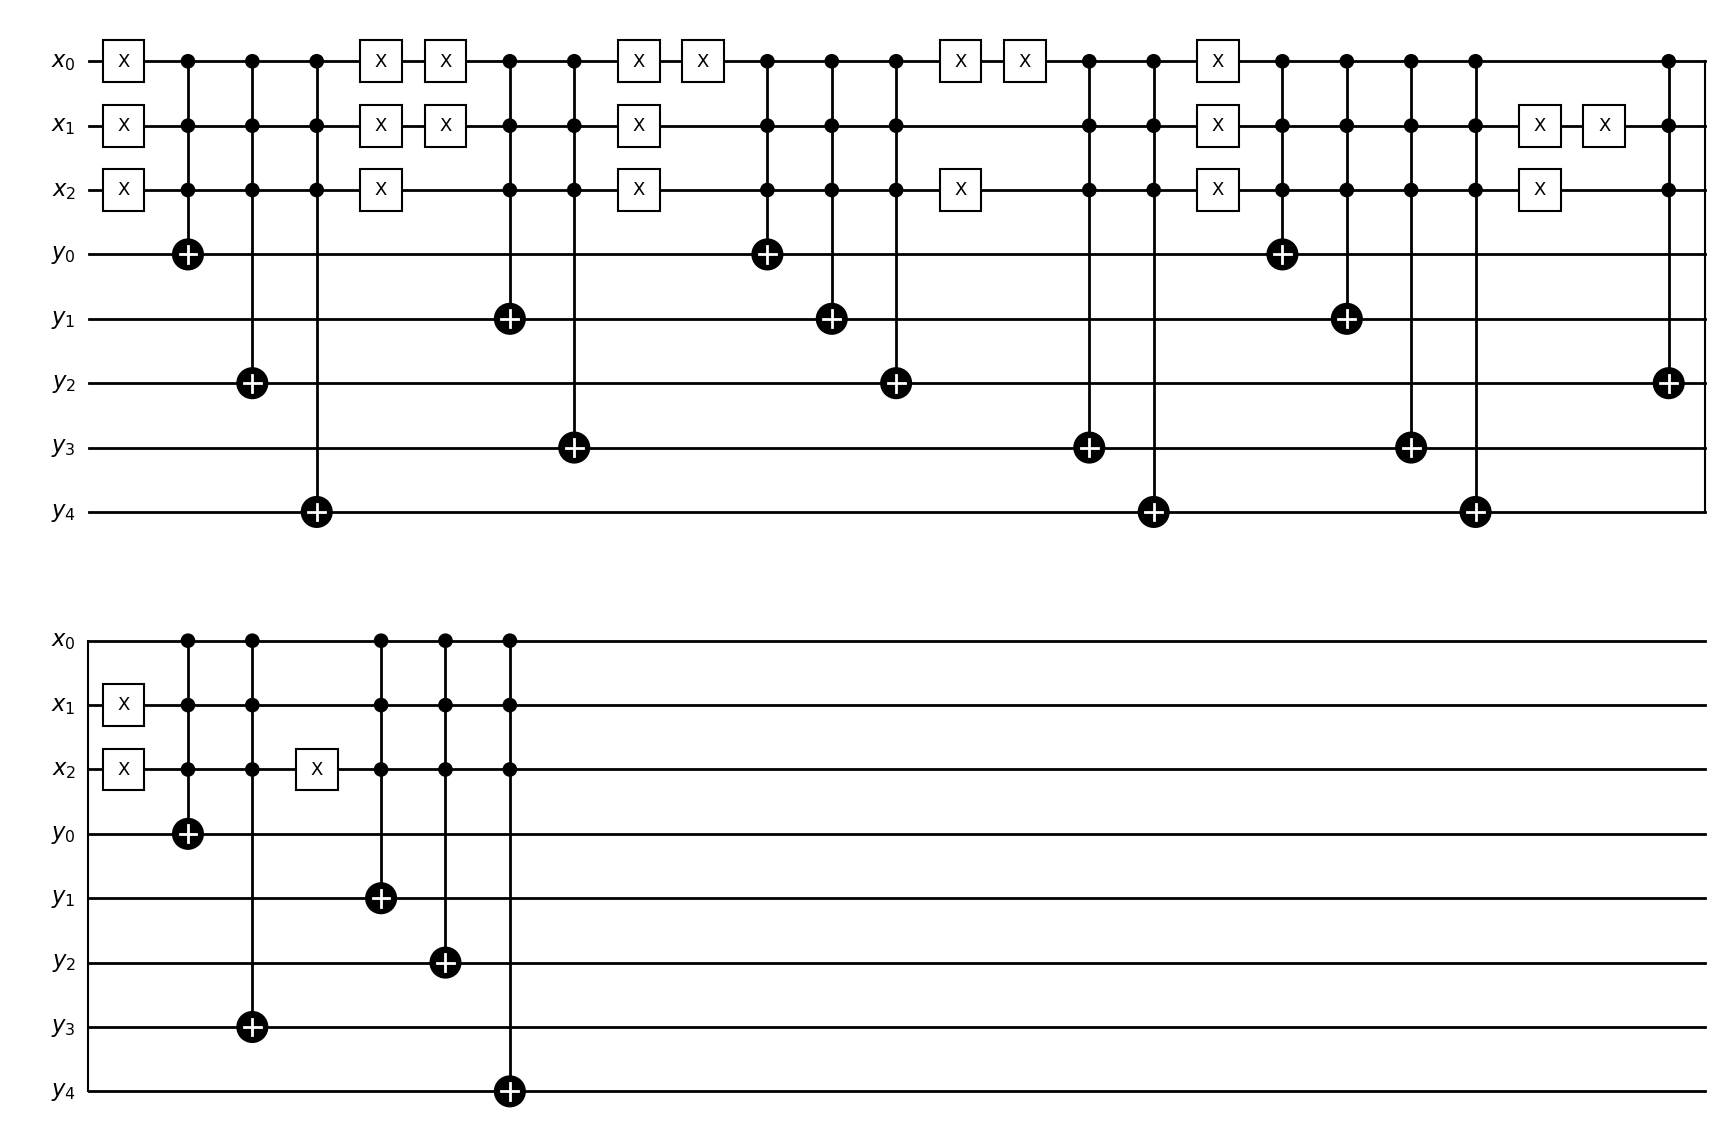

In [3]:
#n = 3, d = 5 example function
def test_function_3_5(x_bits):
    # Example function: f(000) = 10101, f(001) = 01010, f(010) = 11100, f(011) = 00011, f(100) = 11011, f(101) = 00100, f(110) = 10010, f(111) = 01101
    mapping = {
        '000': '10101',
        '001': '01010',
        '010': '11100',
        '011': '00011',
        '100': '11011',
        '101': '00100',
        '110': '10010',
        '111': '01101'
    }
    return mapping[x_bits]

y_3_5 = select_qrom(3, 5, test_function_3_5)
y_3_5.draw(output="mpl", style="bw")

In [60]:
#now we can verify the circuit works as intended
def verify_select(input_bits, test_fn,n,d):
    
    y_n_d = select_qrom(n, d, test_fn)

    expected_output_bits = test_fn(input_bits[0:n])

    quantum_registerX = QuantumRegister(n, name="x")
    quantum_registerY = QuantumRegister(d, name="y")
    qrom_circuit = QuantumCircuit(quantum_registerX, quantum_registerY, name="Select QROM")
    y_n_d_gate = y_n_d.to_gate()
    
    ckt_input_bits = input_bits[::-1] #reverse bit order because of qiskit's bit ordering 

    initial_state = Statevector.from_label(ckt_input_bits) 
    qrom_circuit.initialize(initial_state, range(n+d))
    qrom_circuit.append(y_n_d_gate, qrom_circuit.qubits)
    qrom_circuit.measure_all()

    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(qrom_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts()

    circuit_result_bits = list(counts.keys())[0][::-1] #need to reverse because of qiskit's bit ordering
    output_bits = circuit_result_bits[n:] 
    if(output_bits == expected_output_bits):
        print(f"Test passed for input {input_bits}: got expected output {output_bits}")
    else:
        print(f"Test failed for input {input_bits}: expected {expected_output_bits}, got {output_bits}")


    qrom_circuit.draw(output="mpl", style="bw")

    return [input_bits,output_bits]

In [61]:
#test for all possible inputs for n = 3, d = 5
for i in range(2**3):
    input_bits = format(i, f'0{3}b') + '00000' 
    verify_select(input_bits, test_function_3_5,3,5)


Test passed for input 00000000: got expected output 10101
Test passed for input 00100000: got expected output 01010
Test passed for input 01000000: got expected output 11100
Test passed for input 01100000: got expected output 00011
Test passed for input 10000000: got expected output 11011
Test passed for input 10100000: got expected output 00100
Test passed for input 11000000: got expected output 10010
Test passed for input 11100000: got expected output 01101


The select method woks for n = 3!

## Select-swap method

Again, we'll define the method here and then apply it to a test circuit. 

In [58]:
def select_swap_qrom(n, d, f, barrier=False):
    #n: number of input qubits
    #d: number of output qubits
    #f: function mapping bitstrings of length n to bitstrings of length d

    #choose k to be ceil(n/2)
    k = (n // 2) + (n % 2)

    quantum_registerXL = QuantumRegister(n-k, name="xL")
    quantum_registerXH = QuantumRegister(k, name="xH")
    quantum_registerY = QuantumRegister(d*(2**k), name="y")
    qrom_circuit = QuantumCircuit(quantum_registerXL,quantum_registerXH, quantum_registerY, name="Select-Swap QROM")

    def fk(xL_bits):
        #returns fk defined by the function of f applied to the extended xL bits
        big_fk = ""
        for i in range(2**k):
            x_append_bits = format(i, f'0{k}b')
            x_append_bits = x_append_bits[::-1]
            x_bits = xL_bits + x_append_bits
            f_x = f(x_bits)
            big_fk += f_x
        return big_fk
    
    #select step
    sel = select_qrom(n - k, d * (2**k), fk)
    qrom_circuit.append(sel.to_gate(), quantum_registerXL[:] + quantum_registerY[:])

    #swap step
    for i in range(k)[::-1]:
        for j in range(2**i):
            for bit_index in range(d):
                ind1 = j*d + bit_index
                ind2 = (j + (2**i))*d + bit_index
                qrom_circuit.cswap(quantum_registerXH[i], quantum_registerY[ind1], quantum_registerY[ind2])
            if barrier:
                qrom_circuit.barrier() #for visualization purposes, default off for actual use

    return qrom_circuit

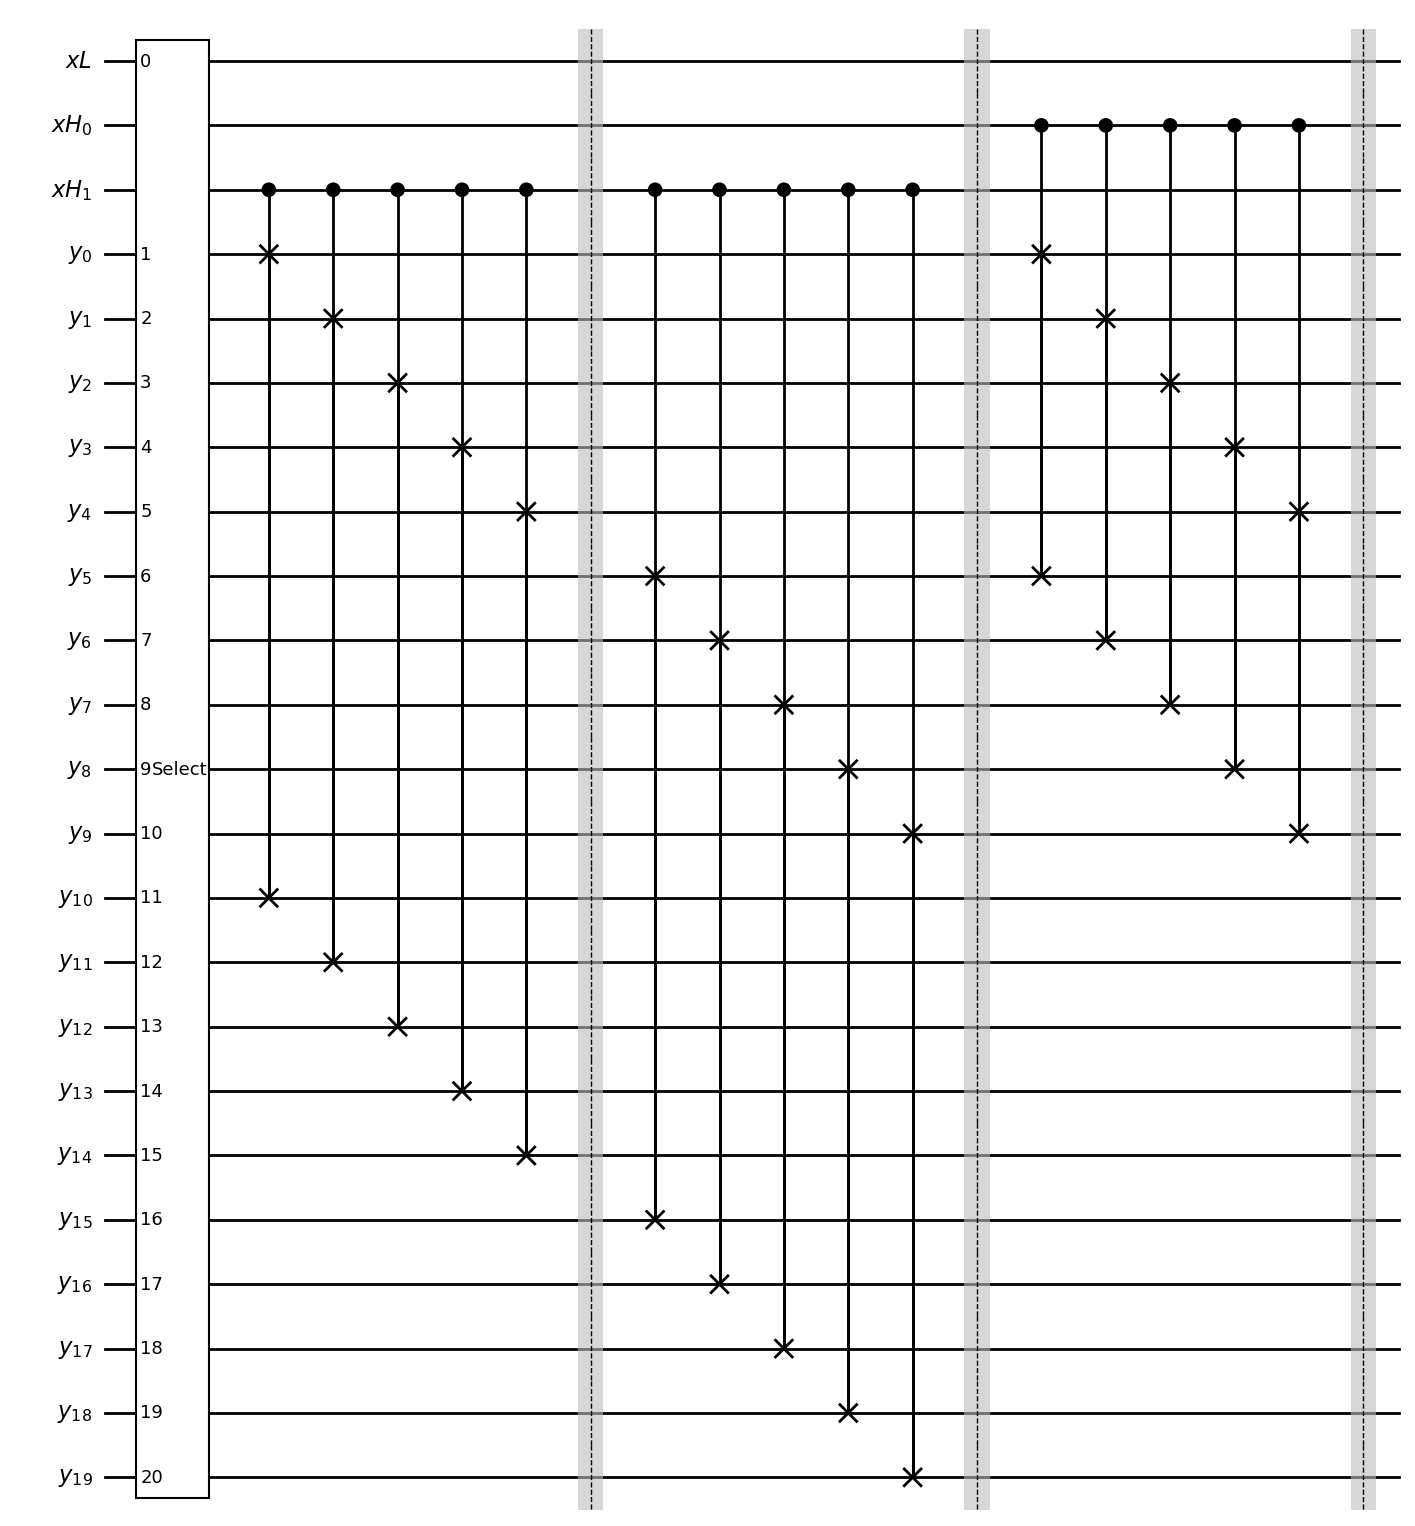

In [59]:
y_3_5 = select_swap_qrom(3, 5, test_function_3_5,barrier=True)
y_3_5.draw(output="mpl", style="bw")

In [ ]:
def verify_select_swap(input_bits, test_fn,n,d):
    
    y_n_d = select_swap_qrom(n, d, test_fn)

    expected_output_bits = test_fn(input_bits[0:n])

    k = (n // 2) + (n % 2)
    quantum_registerX = QuantumRegister(n, name="x")
    quantum_registerY = QuantumRegister(d*(2**(k)), name="y")
    qrom_circuit = QuantumCircuit(quantum_registerX, quantum_registerY, name="Select-Swap QROM")
    y_n_d_gate = y_n_d.to_gate()
    
    ckt_input_bits = input_bits[::-1] #reverse bit order because of qiskit's bit ordering 

    initial_state = Statevector.from_label(ckt_input_bits) 
    qrom_circuit.initialize(initial_state, range(n+d*2**(k)))
    qrom_circuit.append(y_n_d_gate, qrom_circuit.qubits)
    qrom_circuit.measure_all()

    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(qrom_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts()

    circuit_result_bits = list(counts.keys())[0][::-1] #need to reverse because of qiskit's bit ordering
    output_bits = circuit_result_bits[n:n+d] #need to stop at n+d because the select-swap method output garbage in addition to the desired output
    if(output_bits == expected_output_bits):
        print(f"Test passed for input {input_bits}: got expected output {output_bits}")
    else:
        print(f"Test failed for input {input_bits}: expected {expected_output_bits}, got {output_bits}")


    qrom_circuit.draw(output="mpl", style="bw")

    return [input_bits,output_bits]

In [68]:
#test for all possible inputs for n = 3, d = 5
for i in range(2**3):
    input_bits = format(i, f'0{3}b') + '0'*5*2**((3 // 2) + (3 % 2)) 
    verify_select_swap(input_bits, test_function_3_5,3,5)

Test passed for input 00000000000000000000000: got expected output 10101
Test passed for input 00100000000000000000000: got expected output 01010
Test passed for input 01000000000000000000000: got expected output 11100
Test passed for input 01100000000000000000000: got expected output 00011
Test passed for input 10000000000000000000000: got expected output 11011
Test passed for input 10100000000000000000000: got expected output 00100
Test passed for input 11000000000000000000000: got expected output 10010
Test passed for input 11100000000000000000000: got expected output 01101


Again, all tests passed!